# Estadisticas De Casos de COVID-19 en México y sus entidades
    Autor: Eduardo Alán Hernández Villasana
    Estudiante de Licenciatura en Ciencias Computacionales en
    la Universidad Autonoma de Nuevo León - Facultad de Ciencias Fisico Matemáticas

In [1]:
import pandas as ps
import os
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
# Función para invertir el dia y mes en el formato de fecha, esto para poder ordenar las fechas
def invertirLista (cadenas):
    cadenas_nueva = []
    for cadena in cadenas:
        elementos = cadena.split('/')
        cadenas_nueva.append (elementos[1] +"/"+ elementos[0] +"/"+ elementos[2])
    return cadenas_nueva

In [3]:
# Función para obtener el dataframe desde un url, también calcula la fecha y obtiene el dataframe de el dia actual o el de ayer
def obtenerDataFrame (fecha = "hoy"):
    #url = "https://raw.githubusercontent.com/EduHdzVillasana/COVIDSTATSMX/master/Datos%20Abiertos"
    url = "C:/Users/alana/Documents/COVIDSTATSMX/Datos Abiertos"
    x = dt.date.today()
    fecha = str(x)
    sufijo = "COVID19MEXICO.csv"
    # 200617COVID19MEXICO.csv
    año = str(x.year - 2000)
    if x.month >= 10:
        mes = str(x.month)
    else:
        mes = "0" + str(x.month)
    
    if x.day >= 10:
        dia = str(x.day)
    else:
        dia = "0" + str(x.day)

    prefijo = año + mes + dia
    try:
        covid_df = ps.read_csv(url + "/" + prefijo + sufijo)
        print ("DataSet obtenido de: \n" + url + "/" + prefijo + sufijo)
    except:
        x = x - dt.timedelta(days = 1)
        fecha = str(x)
        año = str(x.year - 2000)
        if x.month >= 10:
            mes = str(x.month)
        else:
            mes = "0" + str(x.month)
        
        if x.day >= 10:
            dia = str(x.day)
        else:
            dia = "0" + str(x.day)

        prefijo = año + mes + dia
        try:
            covid_df = ps.read_csv(url + "/" + prefijo + sufijo)
            print ("DataSet obtenido de: \n" + url + "/" + prefijo + sufijo)
        except:
            covid_df = None
            fecha = "0"
    #print (dt.datetime.now() - x) Para medir el tiempo que se tarda en leer el dataset
    return covid_df, fecha

In [4]:
# Guarda un dataframe dependiendo de el nombre, el path y especificando que tipo de extencion y formatp
def guardarDataFrame (path = "C:", nombre = "DATAFRAME", tipo = ".xls", dataFrame = None):
    if tipo == ".csv":
        dataFrame.to_csv(os.path.join(path, nombre))
    elif tipo == ".xls":
        dataFrame.to_excel(os.path.join(path, nombre))
    elif tipo == ".json":
        dataFrame.to_json(os.path.join(path, nombre))

In [5]:
# Imprime los datos acumulados
def imprimirAcumulados (casosA):
    # variable que guarda el indice de letalidad en porcentaje
    inice_L = casosA["Defunciones"] / casosA["Positivos"] * 100
    # Variable que guarda el indice de positividad nacional
    indice_P = casosA["Positivos"] / (casosA["Negativos"] + casosA["Positivos"]) * 100
    print ("  Total de casos estudiados: " + str(casosA["Total"])+ "\n\n" +
            "  Casos Positivos a SARS-CoV-2: " + str(casosA["Positivos"])+ "\n\n" +
            "  Casos No Positivos a SARS-CoV-2: " + str(casosA["Negativos"])+ "\n\n" +
            "  Casos Con Resultado Pendiente: " + str(casosA["Pendientes"]) + "\n\n" +
            "  Defunciones Positicas a SARS-CoV-2: " + str(casosA["Defunciones"]) + "\n\n" +
            "  Tasa de Letalidad: %.3f%s\n\n  Tasa de Positividad : %.3f%s\n" % (inice_L,"%",indice_P,"%"))

In [6]:
# Guarda en un diccionario los casos acumulados
def obtenerCasosAcumulados (covid_df):
    # Data Frame que almacenará la columna RESULTADO donde 1 es positivo, 2 es negativo, 3 es pendiente y FECHA_DEF, donde si la fecha es diferente a 9999-99-99 es una defuncion
    #casos = ps.concat([covid_df["RESULTADO"], covid_df["FECHA_DEF"]], axis = 1)
    
    casos = covid_df[["RESULTADO", "FECHA_DEF"]]
    # Contador de los casos positivos
    positivos = 0 
    # Contador de los casos negativos
    negativos = 0
    # Contador de los casos pendientes
    pendientes = 0
    # Contador de defunciones por covid-19
    defunciones = 0
    #print (casos.head())
    for i in range (len(casos)):
        if casos["RESULTADO"][i] == 1:
            positivos += 1
            if casos ["FECHA_DEF"][i] != "9999-99-99":
                defunciones +=1
        elif casos["RESULTADO"][i] == 2:
            negativos += 1
        elif casos["RESULTADO"][i] == 3:
            pendientes +=1
    return {"Positivos": positivos, "Negativos":negativos, "Pendientes":pendientes, "Defunciones": defunciones, "Total": len(casos)}

In [7]:
# Filtra los datos y obtiene un diccionario con los casos registradps por dia
# Esta añadida la opcion de especificar el estado y la lista de municipios
def obtenerCasosPorDia (covid_df, estado = 0, municipios = []):
    # Lista que guarda las fechas de FECHA
    fechas = []
    # Diccionario que guarda la posicion de las fechas
    pos_fechas = {}
    # Diccionario que se convertirá en Data Frame
    casosPorDia = {}
    # Se crean las listas que almacenarán los datos
    casosPorDia ["FECHA"] = []
    casosPorDia ["CASOS_POSITIVOS"] = []
    casosPorDia ["CASOS_NEGATIVOS"] = []
    casosPorDia ["CASOS_SOSPECHOSOS"] = []
    casosPorDia ["DEFUNCIONES"] = []
    total_Casos = len(covid_df)
    # Se crea la lista de las fechas
    for i in range(total_Casos):
        if covid_df["FECHA_SINTOMAS"][i] not in fechas:
            #print (covid_df["FECHA_SINTOMAS"][i])
            fechas.append(covid_df["FECHA_SINTOMAS"][i])
    
    # Se ordenan las fechas, debido al formato (dd/mm/aaaa) se tiene que invertir a (mm/dd/aaaa) para ordenarlo y después se devuelven a 
    # su posicion original
    fechas = invertirLista(fechas)
    fechas.sort()
    fechas = invertirLista(fechas)
    casosPorDia ["FECHA"] = fechas
    # Se filtran los datos y se cuentan los casos positivos, negativos, sospechosos, y defunciones confirmadas por cada fecha
    # Para los casos positivos, negativos y sospechosos la columna "FECHA" representa su fecha de inicio de sintomas, 
    # mientras que para las defunciones, la columna "FECHA" representa la fecha de defunción.
    # No se debe olvidar que aqui solamente se muestran numeros frios, pero cada una de las defunciones representa una vida perdida.
    
    for fecha in casosPorDia["FECHA"]:

        casos_P = covid_df[(covid_df["FECHA_SINTOMAS"] == fecha) 
        & (covid_df["RESULTADO"] == 1) 
        & ((covid_df["ENTIDAD_RES"] == estado) |( estado == 0)) 
        & ((covid_df["MUNICIPIO_RES"].isin (municipios)) | (len(municipios) == 0))]

        casos_N = covid_df[(covid_df["FECHA_SINTOMAS"] == fecha) 
        & (covid_df["RESULTADO"] == 2) 
        & ((covid_df["ENTIDAD_RES"] == estado) |( estado == 0)) 
        & ((covid_df["MUNICIPIO_RES"].isin (municipios)) | (len(municipios) == 0))]

        casos_S = covid_df[(covid_df["FECHA_SINTOMAS"] == fecha) 
        & (covid_df["RESULTADO"] == 3) 
        & ((covid_df["ENTIDAD_RES"] == estado) |( estado == 0)) 
        & ((covid_df["MUNICIPIO_RES"].isin (municipios)) | (len(municipios) == 0))]

        Def = covid_df[(covid_df["FECHA_DEF"] == fecha) 
        & (covid_df["RESULTADO"] == 1) 
        & ((covid_df["ENTIDAD_RES"] == estado) |( estado == 0)) 
        & ((covid_df["MUNICIPIO_RES"].isin (municipios)) | (len(municipios) == 0))]

        casosPorDia ["CASOS_POSITIVOS"].append(len(casos_P))
        casosPorDia ["CASOS_NEGATIVOS"].append(len(casos_N))
        casosPorDia ["CASOS_SOSPECHOSOS"].append(len(casos_S))
        casosPorDia ["DEFUNCIONES"].append(len(Def))
    return casosPorDia

In [8]:
zonaMetroMty = [39,26,6,46,21,48,31,18,19,9,49,43]
NuevoLeon = 19
covid_df, fecha_actualizacion = obtenerDataFrame()

DataSet obtenido de: 
C:/Users/alana/Documents/COVIDSTATSMX/Datos Abiertos/200902COVID19MEXICO.csv


In [9]:
fecha_actualizacion

'2020-09-02'

In [10]:
covid_df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,02/09/2020,194e4a,2,3,27,1,7,27,4,2,...,2,2,2,2,1,1,99,MÃ©xico,99,2
1,02/09/2020,99786,2,4,25,2,25,25,6,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97
2,02/09/2020,097d14,2,3,2,2,2,2,2,1,...,2,2,2,2,1,1,99,MÃ©xico,99,97
3,02/09/2020,18eb28,2,4,28,1,28,28,27,1,...,2,1,2,2,1,1,99,MÃ©xico,99,97
4,02/09/2020,1b7adb,2,4,2,2,12,2,4,2,...,2,2,2,2,99,1,99,MÃ©xico,99,2


In [11]:
casosAcumulados = obtenerCasosAcumulados(covid_df)
imprimirAcumulados (casosAcumulados)

Total de casos estudiados: 1048575

  Casos Positivos a SARS-CoV-2: 610957

  Casos No Positivos a SARS-CoV-2: 422006

  Casos Con Resultado Pendiente: 15612

  Defunciones Positicas a SARS-CoV-2: 65816

  Tasa de Letalidad: 10.773%

  Tasa de Positividad : 59.146%



In [12]:
casosPorDia_dict = obtenerCasosPorDia(covid_df)
casosPorDia_df = ps.DataFrame(casosPorDia_dict)
print(casosPorDia_df.head())

FECHA  CASOS_POSITIVOS  CASOS_NEGATIVOS  CASOS_SOSPECHOSOS  \
0  01/01/2020                0               21                  0   
1  02/01/2020                0               20                  0   
2  03/01/2020                0               16                  0   
3  04/01/2020                0               19                  0   
4  05/01/2020                0               26                  0   

   DEFUNCIONES  
0            0  
1            0  
2            0  
3            0  
4            0  


In [13]:
casosPorDia_dict = obtenerCasosPorDia(covid_df, NuevoLeon, zonaMetroMty)
ZM_MTY_df = ps.DataFrame(casosPorDia_dict)
print(ZM_MTY_df.head())

FECHA  CASOS_POSITIVOS  CASOS_NEGATIVOS  CASOS_SOSPECHOSOS  \
0  01/01/2020                0                0                  0   
1  02/01/2020                0                0                  0   
2  03/01/2020                0                1                  0   
3  04/01/2020                0                0                  0   
4  05/01/2020                0                0                  0   

   DEFUNCIONES  
0            0  
1            0  
2            0  
3            0  
4            0  


In [14]:
guardarDataFrame (path = "C:/Users/alana/Documents/COVIDSTATS/CASOSPORDIA",
nombre = fecha_actualizacion + "-ZONA-METRO-MTY.xls",
tipo = ".xls",
dataFrame = ZM_MTY_df)
guardarDataFrame (path = "C:/Users/alana/Documents/COVIDSTATS/CASOSPORDIA",
nombre = fecha_actualizacion + "-NACIONAL.xls",
tipo = ".xls",
dataFrame = casosPorDia_df)

Text(0.5, 1.0, 'CASOS POSITIVOS NACIONALES (ROJO)\nDEFUNCIONES NACIONALES (AZUL)')

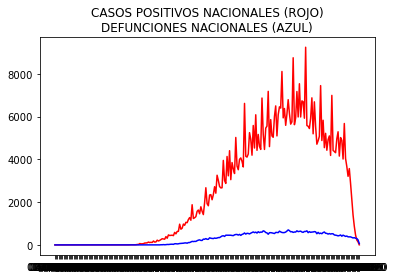

In [15]:
%matplotlib inline
plt.plot(casosPorDia_df["FECHA"],casosPorDia_df["CASOS_POSITIVOS"],"r")
plt.plot(casosPorDia_df["FECHA"],casosPorDia_df["DEFUNCIONES"],"b")
plt.title("CASOS POSITIVOS NACIONALES (ROJO)\nDEFUNCIONES NACIONALES (AZUL)")

Text(0.5, 1.0, 'CASOS POSITIVOS NUEVO LEÓN (ROJO)\nDEFUNCIONES NUEVO LEÓN (AZUL)')

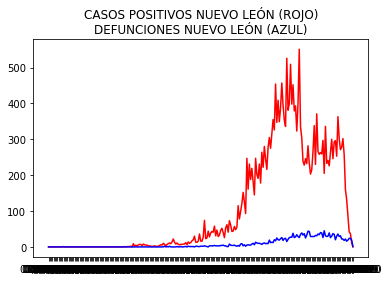

In [16]:
%matplotlib inline
plt.plot(ZM_MTY_df["FECHA"],ZM_MTY_df["CASOS_POSITIVOS"],"r")
plt.plot(ZM_MTY_df["FECHA"],ZM_MTY_df["DEFUNCIONES"],"b")
plt.title("CASOS POSITIVOS NUEVO LEÓN (ROJO)\nDEFUNCIONES NUEVO LEÓN (AZUL)")